In [1]:
import os, pathlib
os.chdir(pathlib.Path(globals()['_dh'][0]).parent)

# Animation + Plot Example

pendsim includes the ability to generate animated plots alongside the animation of the simulation. This is helpful when visualizing specific pendulum states along with the animation. For this example, we will create a PID controller with an Unscented Kalman Filter, and then visualize the measured state with the filtered measurements to see how this functionality might be used.

Arrange imports

In [2]:
from pendsim import sim, controller, viz
import numpy as np
import matplotlib.pyplot as plt

Create a pendulum with a 2kg cart, 1kg mass, and 2-meter length. The initial state is given by the `initial_state` arg. The state array is $\textbf{x}=[x, \dot{x}, \theta, \dot{\theta}]$ So in this case the pendulum starts slightly tipped over: $\theta = 0.1$.

In [3]:
pend = sim.Pendulum(
    2.0,
    1.0,
    2,0,
    initial_state = np.array([0.0, 0.0, 0.1, 0.0])
)

Create a PID controller with gains `kp`, `ki`, `kd`. For this example, we use the PID controller with an unscented Kalman Filter, so that we can visualize in real time the filter's performance at estimating the state (given as noisy, discrete points).

PID_UKF takes one additional argument, `var_t`, which is the backwards window, in seconds, over which to measure the variance in the state. So, at every point, we look backward over a period of 0.2s, measure the variance, and then use the variance to estimate the true state from noise via Unscented Kalman Filtering. For more details about Unscented Kalman Filtering, see https://groups.seas.harvard.edu/courses/cs281/papers/unscented.pdf.

`dt` is the timestep of the simulation. Because the simulation solves an I.V.P (Initial Value Problem) at every timestep to determine the simulated pendulum's position, `dt` can be large without introducing numerical errors. The controller's action is taken at intervals of `dt` and held constant throughout the interval. We must pass the same value for `dt` to the controller as is used by the simulation.

So, because we are creating the controller here, `dt` is specified here.

In [4]:
kp, ki, kd = 20.0, 0.0, 2.0

dt = 0.02

cont = controller.PID_UKF(
    # PID gains
    (kp, ki, kd), 
    pend,
    dt,
    # var_t
    0.2
)

Create a simulation object with a timestep `dt`, run time `t_final`, and an 20N impulse force that peaks at t= 2seconds

In [5]:
t_final = 12.0
def force(t):
    return 20 * np.exp( -((t-2.0)/0.1)**2 )

noise_scale = np.array([0.1,0.1,0.1,0.1])

simu = sim.Simulation(dt, t_final, force, noise_scale=noise_scale)

Run the simulation with the pendulum and controller we created and store the simulation results into `results`

In [6]:
results = simu.simulate(pend, cont)

  0%|          | 0/600 [00:00<?, ?it/s]

  2%|▏         | 9/600 [00:00<00:06, 87.33it/s]

  5%|▍         | 29/600 [00:00<00:03, 150.29it/s]

  9%|▊         | 52/600 [00:00<00:02, 185.86it/s]

 12%|█▎        | 75/600 [00:00<00:02, 201.15it/s]

 16%|█▋        | 98/600 [00:00<00:02, 211.13it/s]

 20%|██        | 121/600 [00:00<00:02, 216.52it/s]

 24%|██▍       | 144/600 [00:00<00:02, 218.55it/s]

 28%|██▊       | 167/600 [00:00<00:01, 219.27it/s]

 32%|███▏      | 190/600 [00:00<00:01, 219.68it/s]

 36%|███▌      | 213/600 [00:01<00:01, 222.19it/s]

 39%|███▉      | 236/600 [00:01<00:01, 223.25it/s]

 43%|████▎     | 259/600 [00:01<00:01, 224.41it/s]

 47%|████▋     | 282/600 [00:01<00:01, 222.99it/s]

 51%|█████     | 305/600 [00:01<00:01, 224.27it/s]

 55%|█████▍    | 328/600 [00:01<00:01, 225.23it/s]

 59%|█████▊    | 352/600 [00:01<00:01, 227.80it/s]

 62%|██████▎   | 375/600 [00:01<00:01, 185.98it/s]

 66%|██████▋   | 399/600 [00:01<00:01, 198.45it/s]

 70%|███████   | 422/600 [00:02<00:00, 205.79it/s]

 74%|███████▍  | 445/600 [00:02<00:00, 211.97it/s]

 78%|███████▊  | 469/600 [00:02<00:00, 217.17it/s]

 82%|████████▏ | 492/600 [00:02<00:00, 219.45it/s]

 86%|████████▌ | 515/600 [00:02<00:00, 222.01it/s]

 90%|████████▉ | 538/600 [00:02<00:00, 222.04it/s]

 94%|█████████▎| 561/600 [00:02<00:00, 221.41it/s]

 97%|█████████▋| 584/600 [00:02<00:00, 218.03it/s]

100%|██████████| 600/600 [00:02<00:00, 213.01it/s]

We can see the available states by printing `results.columns`.

The `pltdata` dict stores all of the parameters for generating the animated plot. There are two types of animated plots: line plots and scatter plots. For line plots, we must supply the `linestyle` argument; for both types of plot, we must supply `label`, `color`, and `plotpoints` args. The key of `pltdata` is the same as the column contained in `results` that we want to measure and display in the animation.

In this example, we display the "true state" theta, given by `('state', 't')`; the state actually measured by the controller, given by `('measured state', 't')`; and the estimated state, given by `('est','t')`. Note that the `('est','t')` column is one that is stored directly by the controller's `policy`.

In [7]:
print(results.columns)
pltdata = {
    ('state', 't') : {
        # The plot type, line or scatter
        'type' : 'line',
        # The label generated in the plot window
        'label' : 'true theta',
        # The style of the line, e.g. '--' produces a dotted line
        'linestyle' : '-',
        # The line color
        'color' : 'r',
        # The number of plot points to draw on the canvas
        'plotpoints' : 50,
    },
    ('measured state', 't') : {
        # scatter types don't need `linestyle` kwarg.
        'type' : 'scatter',
        'label' : 'measured theta',
        'color' : 'k',
        'plotpoints' : 50,
    },
    ('est', 't') : {
        'type' : 'line',
        'label' : 'estimated theta',
        'linestyle':'--',
        'color' : 'g',
        'plotpoints': 50,
    }
}

MultiIndex([(         'state',              'x'),
            (         'state',             'xd'),
            (         'state',              't'),
            (         'state',             'td'),
            ('measured state',              'x'),
            ('measured state',             'xd'),
            ('measured state',              't'),
            ('measured state',             'td'),
            ('noise variance',              'x'),
            ('noise variance',             'xd'),
            ('noise variance',              't'),
            ('noise variance',             'td'),
            (           'res',              'x'),
            (           'res',             'xd'),
            (           'res',              't'),
            (           'res',             'td'),
            (           'est',              'x'),
            (           'est',             'xd'),
            (           'est',              't'),
            (           'est',             'td'),


Make an animation of the simulation. Make sure to bind the result of `visu.animate()` to a variable, because that is required in order to ensure that the animation will actually run.

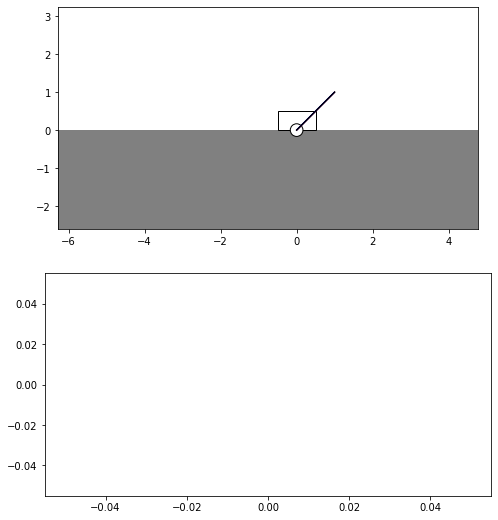

In [8]:
visu = viz.Visualizer(results, pend, dt, speed=1)
ani = visu.animate(pltdata=pltdata)

In web-based notebooks, animations may not display correctly with just the matplotlib plots. It may be necessary to run the following cell to render and view an HTML5 video of the animation.

In [9]:
from IPython.display import HTML
HTML(ani.to_html5_video())